# Simulate XMM EPIC images with double King profiles

Parameters taken from Jukka Nevalainen for Abell 1795

**Requirements**: 
* python 3.7 and the following packages: `astropy`, `photutils`, `APLpy`
* XMM EPIC images for each instrument and band
* XMM EPIC detector mask images for each instrument and band

The detector mask can be created with `XMM-SAS` using the image and the expomap.

Author: Ivan Valtchanov, ESAC, Oct 2018

In [2]:
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pylab as plt

import os
import numpy as np

import aplpy

from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The radially symmetric doble-$\beta$ model we use:

$S(r) = S_{cool}(0)\left[ 1 + \left(r/r_{cool}\right)^2\right]^{0.5-3\beta} + S_{amb}(0)\left[ 1 +\left(r/r_{amb}\right)^2\right]^{0.5-3\beta}$ 

The parameters are explained in the comments to the function.

In [4]:
def king2betaX(xin,yin,s0_cool,s0_amb,r_cool,r_amb,beta_cool,beta_amb):
    #
    # (xin, yin) are the input coordinates
    # The following prarameters are for the two components: 
    # `cool` is for the central cool core region, `amb` is for the ambient region
    # s0_cool, s0_amb are the normalisations for each component (in cts/s/arcmin^2)
    # r_cool,r_amb are the characteristic scales for each component (in arcmin)
    # beta_cool,beta_amb are the slopes for each component
    #
    rx = np.sqrt(xin*xin + yin*yin)
    r2_cool = np.power((rx/r_cool),2)
    r2_amb = np.power((rx/r_amb),2)
    #
    bx1 = 0.5 - 3*beta_cool
    bx2 = 0.5 - 3.0*beta_amb
    scool = s0_cool*np.power((1.0 + r2_cool),bx1)
    samb = s0_amb*np.power((1.0 + r2_amb),bx2)
    #
    total = scool + samb
    return total


## 1. Read the image and the detector mask

In [5]:
#
# set up the working directory and the instrument to simulate
#
wdir =  '/lhome/ivaltchanov/XMM-clusters/A1795/0097820101/proc_161'
#wdir =  '../data'
#
# instrument
#
instrument = "pn"
#instrument = "mos1"
#instrument = "mos2"

In [6]:
#
# read the image and the detector mask, change the names to match the settings
#
image = f'{wdir}/{instrument}_image_500_7000.fits'
expo = f'{wdir}/{instrument}_expimage_500_7000.fits'
# exposure map generated with attrebin=0.02
expox = f'{wdir}/{instrument}_expimage_500_7000_test002.fits'
detmask = f'{wdir}/{instrument}_detmask_500_7000.fits'
#
# read the FITS files
hdu1 = fits.open(image)
hdu2 = fits.open(detmask)
hdu3 = fits.open(expo)
hdu4 = fits.open(expox)

## 2. Generate a grid

The grid over which the surface brighness will be calulated. This is in pixels and the clusyer centre will have grid coordinates (0,0).

In [7]:
#
# get the WCS of the image and set up the centre of the cluster
#
wcs = WCS(hdu1[0].header)
center = SkyCoord(207.2208333,26.59027778,unit=(u.deg,u.deg),frame='icrs')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [8]:
nx,ny = hdu1[0].data.shape
y, x = np.mgrid[0:ny, 0:nx]
xy = wcs.wcs_world2pix(center.ra.value,center.dec.value,1)
y = y - xy[1]
x = x - xy[0]

## 3. Evaluate the profile on the grid



In [9]:
# will have to convert the model parameters from arcmin to pixels
arcmin2pix = wcs.pixel_scale_matrix[1,1]*60.0
#
rcool = 0.65 # arcmin
rcore = 2.45 # arcmin
rcool_pix = 0.65/arcmin2pix # pixels
rcore_pix = 2.45/arcmin2pix # pixels
#
betac = 0.72
betaa = 0.72
#
s0c = 6.3 # cts/s/arcmin^2
s0a = 0.83 # cts/s/arcmin^2
s0c_pix = 6.3/(arcmin2pix*arcmin2pix) # cts/s/pix
s0a_pix = 0.83/(arcmin2pix*arcmin2pix) # cts/s/pix
#
profile = king2betaX(x,y,s0c_pix,s0a_pix,rcool_pix,rcore_pix,betac,betaa)
#

## 4. Save the simulated images

The simulated image will replace the image HDU of the original. There are two files on output: one with the ideal profile with no gaps (`simulated_no_mask` in name) and another one, multiplied with the detector mask (only `simulated` in name).

In [10]:
# first save without detector mask
hdu1[0].data = profile
outfile1 = f'{wdir}/{instrument}_500_7000_simulated_nomask.fits'
hdu1.writeto(outfile1,overwrite=True)

In [11]:
# now with the detmask
profile2 = profile*hdu2['MASK'].data
hdu1[0].data = profile2
outfile2 = f'{wdir}/{instrument}_500_7000_simulated.fits'
hdu1.writeto(outfile2,overwrite=True)

In [12]:
# now with exposure mask
emask = hdu3[0].data > 0
profile3 = profile*emask
hdu1[0].data = profile3
outfile3 = f'{wdir}/{instrument}_500_7000_simulated_expo.fits'
hdu1.writeto(outfile3,overwrite=True)

In [13]:
# now with exposure mask with attrebin=0.02
emask = hdu4[0].data > 0
profile4 = profile*emask
hdu1[0].data = profile4
outfile4 = f'{wdir}/{instrument}_500_7000_simulated_expo_attrebin.fits'
hdu1.writeto(outfile4,overwrite=True)

## 5. Aperture photmetry

We use `photutiuls` package to integrate the counts within a used provided aperture. The following 3 quantities are derived:

1. The total counts in the ideal (no detector gaps) simulated image.
2. The total counts in masked image (with detector gaps) simulated image.
3. The total counts in the mask image. This will give the fraction of masked pixels within the aperture.


In [14]:
# define the aperture
aperture = SkyCircularAperture(center, r=4. * u.arcmin)
# the aperture radius in pixels
aper_pix = aperture.to_pixel(wcs)
# the aperture area in pixels
aper_area = aperture.to_pixel(wcs).area()

In [16]:
hdu2.info()

Filename: /lhome/ivaltchanov/XMM-clusters/A1795/0097820101/proc_161/pn_detmask_500_7000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  MASK          1 ImageHDU       171   (648, 648)   int32   


In [20]:
#
# now measure the geometric area of bad pixels
#
photo0 = aperture_photometry(hdu2['MASK'].data, aperture,wcs=wcs)
ap_flux0 = photo0['aperture_sum'][0]
print ("Total flux in aperture, detector: {}, {}".format(ap_flux0,ap_flux0/aper_area))
photo0x = aperture_photometry(emask, aperture,wcs=wcs)
ap_flux0x = photo0x['aperture_sum'][0]
print ("Total flux in aperture, detector: {}, {}".format(ap_flux0x,ap_flux0x/aper_area))

Total flux in aperture, detector: 9076.635351343708, 0.8025507681659055
Total flux in aperture, detector: 10686.852358037826, 0.9449252104139199


In [32]:
#
# now measure the aperture flux in the ideal image
#
photo1 = aperture_photometry(profile, aperture,wcs=wcs)
ap_flux1 = photo1['aperture_sum'][0]
print ("Total flux in aperture, simulated ideal image: {}".format(ap_flux1))

Total flux in aperture, simulated ideal image: 1275085.0422431228


In [33]:
#
# image with detector mask
#
photo2 = aperture_photometry(profile2, aperture,wcs=wcs)
ap_flux2 = photo2['aperture_sum'][0]
print ("Total flux in aperture, simulated image with {} mask: {}".format(instrument,ap_flux2))

Total flux in aperture, simulated image with pn mask: 1085859.5827849042


In [34]:
#
# image with exposure mask
#
photo3 = aperture_photometry(profile3, aperture,wcs=wcs)
ap_flux3 = photo3['aperture_sum'][0]
print ("Total flux in aperture, simulated image with exposure mask: {}".format(ap_flux3))

Total flux in aperture, simulated image with exposure mask: 1199410.559889911


In [35]:
#
# image with attrebin=0.02 exposure mask
#
photo4 = aperture_photometry(profile4, aperture,wcs=wcs)
ap_flux4 = photo4['aperture_sum'][0]
print ("Total flux in aperture, simulated image with exposure mask: {}".format(ap_flux4))

Total flux in aperture, simulated image with exposure mask: 1221576.6731249746


In [37]:
#
# ratios
#
ratio21 = ap_flux2/ap_flux1
ratio31 = ap_flux3/ap_flux1
ratio41 = ap_flux4/ap_flux1
ratio43 = ap_flux4/ap_flux3
print (f"Ratio 21: {ratio21}, ratio 31: {ratio31}, ratio41: {ratio41}, ratio43: {ratio43}")


Ratio 21: 0.8515977733333502, ratio 31: 0.9406514233591152, ratio41: 0.9580354506990243, ratio43: 1.018480838818943


In [15]:
#
# the detector mask
#
photo3 = aperture_photometry(hdu2['MASK'].data, aperture,wcs=wcs)
ap_flux3 = photo3['aperture_sum'][0]
print ("Total flux in aperture, {} detector mask: {}".format(instrument,ap_flux3))

Total flux in aperture, pn detector mask: 9077.635351343422


In [16]:
print ("{} Masked/non-masked fraction (%): {:.1f}".format(instrument,100*(1-ap_flux3/aper_area)))
print ("{} Masked/non-masked image flux(%): {:.1f}".format(instrument,100*(1-ap_flux2/ap_flux1)))

pn Masked/non-masked fraction (%): 19.7
pn Masked/non-masked image flux(%): 14.8


## 6. Plot the results

We show, from left to right:
1. The original XMM EPIC image
2. The ideal simulated image
3. The simulated image with the detector mask
4. The detector mask: black is masked (zero value).

The aperture is indicated with a black circle, the cluster centre with a small red circle. 

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


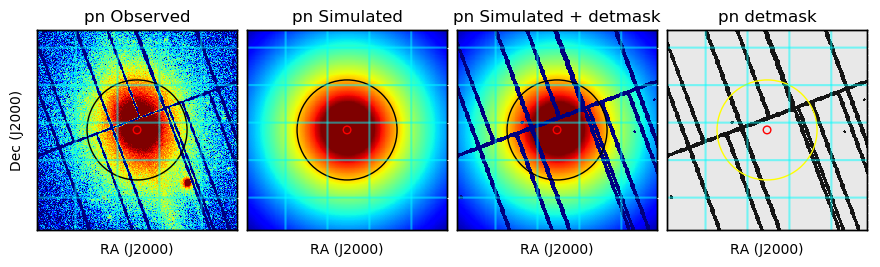

In [17]:
fig = plt.figure(figsize=(10,10),dpi=100)
f0 = aplpy.FITSFigure(image, figure=fig, subplot=[0.1,0.1,0.2,0.2])
f0.show_colorscale(vmin=1,vmax=100,stretch='log')
f0.set_title('{} Observed'.format(instrument))
f0.add_grid()
f0.grid.set_color('cyan')
f0.grid.set_alpha(0.5)
f0.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='black')
f0.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f0.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f0.tick_labels.set_xformat('hh:mm:ss.s')
f0.tick_labels.set_yformat('dd:mm:ss')
f0.hide_ytick_labels()
f0.hide_xtick_labels()
#
f1 = aplpy.FITSFigure(outfile1, figure=fig, subplot=[0.31,0.1,0.2,0.2])
f1.show_colorscale(vmin=1,vmax=100,stretch='log')
f1.set_title('{} Simulated'.format(instrument))
f1.add_grid()
f1.grid.set_color('cyan')
f1.grid.set_alpha(0.5)
f1.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='black')
f1.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f1.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f1.tick_labels.set_xformat('hh:mm:ss.s')
f1.tick_labels.set_yformat('dd:mm:ss')
f1.axis_labels.hide_y()
f1.hide_ytick_labels()
f1.hide_xtick_labels()
#
f2 = aplpy.FITSFigure(outfile2, figure=fig, subplot=[0.52,0.1,0.2,0.2])
f2.show_colorscale(vmin=1,vmax=100,stretch='log')
f2.set_title('{} Simulated + detmask'.format(instrument))
f2.add_grid()
f2.grid.set_color('cyan')
f2.grid.set_alpha(0.5)
f2.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='black')
f2.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f2.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f2.tick_labels.set_xformat('hh:mm:ss.s')
f2.tick_labels.set_yformat('dd:mm:ss')
f2.axis_labels.hide_y()
f2.hide_xtick_labels()
f2.hide_ytick_labels()
#
f3 = aplpy.FITSFigure(detmask, hdu=1,figure=fig, subplot=[0.73,0.1,0.2,0.2])
f3.show_grayscale()
f3.set_title('{} detmask'.format(instrument))
f3.add_grid()
f3.grid.set_color('cyan')
f3.grid.set_alpha(0.5)
f3.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='yellow')
f3.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f3.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f3.tick_labels.set_xformat('hh:mm:ss.s')
f3.tick_labels.set_yformat('dd:mm:ss')
f3.axis_labels.hide_y()
f3.hide_xtick_labels()
f3.hide_ytick_labels()
#
